In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.optimize as so
import scipy.stats as ss
import statsmodels.api as sm
import matplotlib
import random
import copy
import json

from tqdm import tqdm 

matplotlib.rc('font', **{'family' : 'normal','size'   : 18})
# %matplotlib notebook

# Generate data

In [109]:
np.random.seed(2021)
# Get number of data
n = 50

# Generate rho
rho = np.concatenate([np.linspace(0.01,5,5),np.linspace(5,20,35),np.linspace(20,100,10)])

# Define exponential fundamental diagram
def exponential_fd(p):
    return p[0]*rho*np.exp(-p[1]*rho)

# Decide on parameters
alpha = 0.6 # 0.2, 0.6
beta = 0.1 # 0.02, 0.1
# Define noise
sigma2 = 0.0001 # 0.05, 0.1

# Simulate q 
q_true = exponential_fd([alpha,beta])
noise = np.random.multivariate_normal(np.zeros(n),np.eye(n)*sigma2)
q = q_true*np.exp(noise)

## Plot generated data

Text(0, 0.5, '$q$')

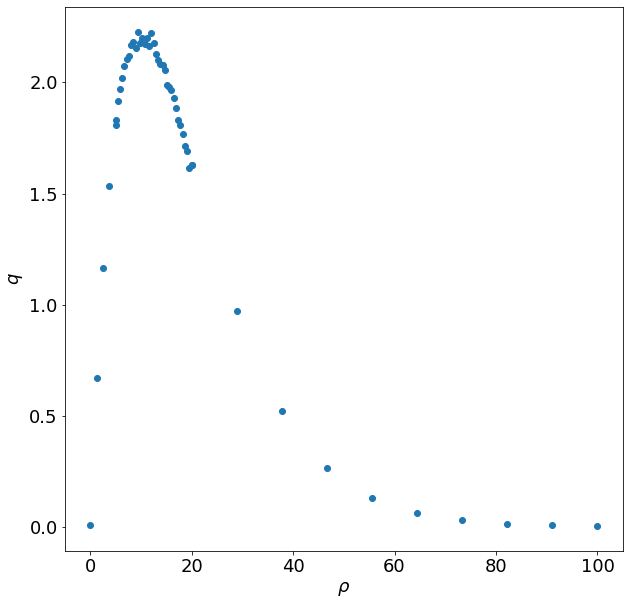

In [110]:
plt.figure(figsize=(10,10))
plt.scatter(rho,q)
plt.xlabel(r'$\rho$')
plt.ylabel(r'$q$')

## Get acceptable ranges for alpha,beta

In [111]:
print(f'alpha = {alpha}, beta = {beta}')

alpha = 0.6, beta = 0.1


In [112]:
alpha_upper = 0.61#0.23, 0.65
beta_upper = 0.105#0.023, 0.12

alpha_lower = 0.59#0.17, 0.55
beta_lower = 0.095#0.017, 0.09
    
q_upper = exponential_fd([alpha_upper,beta_lower])
q_lower = exponential_fd([alpha_lower,beta_upper])

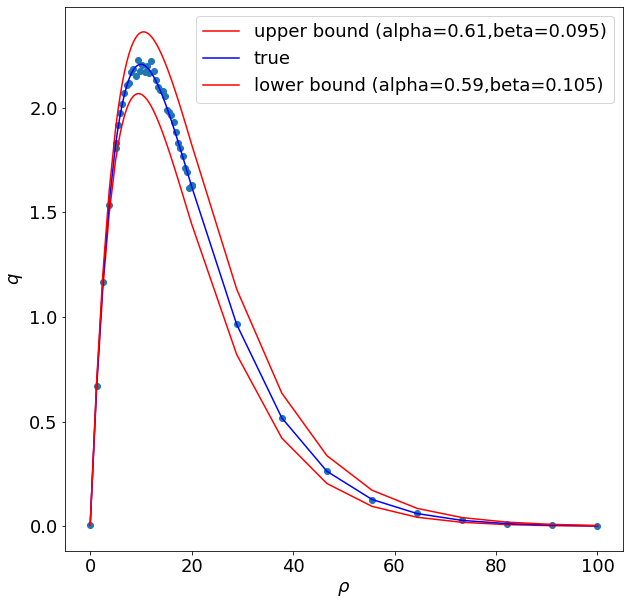

In [113]:
plt.figure(figsize=(10,10))
plt.scatter(rho,q)
plt.plot(rho,q_lower,color='r',label=f'upper bound (alpha={alpha_upper},beta={beta_lower})')
plt.plot(rho,q_true,color='b',label='true')
plt.plot(rho,q_upper,color='r',label=f'lower bound (alpha={alpha_lower},beta={beta_upper})')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$q$')
plt.legend()
plt.ioff()

# Parameter estimation via constrained OLS

In [114]:
# Initial parameter guess
alpha0 = 0.2
beta0 = 0.05
p0 = (alpha0, beta0) 

def exponential_fd_param_squared_error(p):
    return np.sum((q-exponential_fd(p))**2)

def exponential_fd_param_hessian(p):
    _a = p[0]
    _b = p[1]
    return _a*_b**2*rho*np.exp(-_b*rho)-2*_a*_b*np.exp(-_b*rho)

# Define constraints on positivty and concavity
positivity_constraint = so.NonlinearConstraint(exponential_fd,np.ones(len(rho))* np.inf,np.zeros(len(rho)))
concavity_constraint = so.NonlinearConstraint(exponential_fd_param_hessian,np.ones(len(rho))* -np.inf,np.zeros(len(rho)))

# Optimise parameters for least squares
constrained_ls = so.minimize(exponential_fd_param_squared_error, p0, constraints=[positivity_constraint,concavity_constraint],method='BFGS')
constrained_ls_params = constrained_ls.x
constrained_ls_q_hat = exponential_fd(constrained_ls_params)

print(f'Constrained LS alpha = {constrained_ls_params[0]}, beta={constrained_ls_params[1]}, squared error = {int(constrained_ls.fun)}')
print(f'True alpha = {alpha}, beta={beta}')

Constrained LS alpha = 0.599882530108615, beta=0.09988377213613729, squared error = 0
True alpha = 0.6, beta=0.1


/Users/Yannis/.pyenv/versions/3.7.5/envs/ptfm/lib/python3.7/site-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


# Parameter estimation via Marginal Likelihood Estimation

We employ three models



We look at [this paper](https://www.sciencedirect.com/science/article/pii/S0167947309002722) and implement a population MCMC for marginal likelihood estimation.

## Vanilla Metropolis Hastings 

In [115]:
# Define base URL
base_url = '../data/output/models/synthetic/exponential_fd/'
# Define inference method
method = 'grwmh_mcmc'

In [116]:
def grw_mcmc(log_target, kernel, _p0, _y, _K, _N, _beta,seed=None,print_stat:bool=False):
    """ Gaussian Random Walk Metropolis Hastings MCMC method for sampling from pdf defined by log_prior and log_likelihood.
    Inputs:
        log_likelihood - log-likelihood function
        _p0 - initial sample
        _y - observed data
        _sigma2 - prior variance
        _N - number of samples
        _beta - step-size parameter
    Returns:
        _theta - samples from target distribution
        acc/n_iters - the proportion of accepted samples"""
        
#     print('seed',seed)
    np.random.seed(seed)
    
    _theta = []
    _theta_proposed = []
    acc = 0
    p_prev = copy.deepcopy(_p0)
#     print('p0',p_prev)
    
    for i in tqdm(range(_N)):
        
        # Evaluate log 
        lt_prev = log_target(p_prev, _y)

        # Propose new sample using GRW proposal
        p_new = kernel(p_prev,_beta,_K)
        
        lt_new = log_target(p_new, _y)    
            
        # Printing proposals every 0.1*Nth iteration 
        if print_stat and i in [int(j/10*_N) for j in range(1,11)]:
            print('p_prev',p_prev,'lt_prev',lt_prev)
            print('p_new',p_new,'lt_new',lt_new)
            print(f'Acceptance rate {int(100*acc / _N)}%')

        # TODO: Calculate GRW acceptance probability
        log_acc = lt_new - lt_prev
        log_u = np.log(np.random.random())
#         print('lt_new',lt_new)
#         print('lt_prev',lt_prev)
#         print('log_u',log_u)

        # Accept/Reject
        # Compare log_alpha and log_u to accept/reject sample
        if min(np.exp(log_acc),1) >= np.exp(log_u):
            if print_stat and i in [int(j/10*_N) for j in range(1,11)]:
                print('Accepted!')
                print('p_new =',p_prev)
            acc += 1
            _theta.append(p_new)
            p_prev = p_new
            _theta_proposed.append(p_new)
        else:
#             if print_stat or i in [int(j/10*_N) for j in range(1,11)]: print('Rejected...')
            _theta.append(p_prev)
            _theta_proposed.append(p_new)

    return np.array(_theta), np.array(_theta_proposed), acc / _N


def gelman_rubin_statistic(posterior_samples,r_critical:float=1.1):
    # See more details here: https://pymc-devs.github.io/pymc/modelchecking.html
    # Get number of chain iterations and number of chains
    _n,_m = posterior_samples.shape
    # Compute posterior mean for each parameter dimension
    posterior_parameter_means = np.array([np.mean(posterior_samples[:,j]) for j in range(_m)])
#     print('Computing B')
    # Compute B
    _B = _n/(_m-1) * np.sum([(posterior_parameter_means[j] - np.mean(posterior_samples,axis=(0,1)))**2 for j in range(_m)])
    # Compute W
#     print('Computing W')
    _W = (1./_m) * np.sum([(1./(_n-1)* np.sum([(posterior_samples[i,j]-posterior_parameter_means[j])**2 for i in range(_n)])) for j in range(_m)])
    # Compute parameter marginal posterior variance
#     print('Computing marginal posterior variance')
    posterior_marginal_var = ((_n-1)/_n)*_W + _B/_n
    # Compute R stastic
#     print('Computing marginal posterior variance')
    r_stat = np.sqrt(posterior_marginal_var/_W)
    
    # Decide if convergence was achieved
    if r_stat < r_critical: print(r'MCMC chains have converged with $\hat{R}$=',r_stat,'!')
    else: print(r'MCMC chains have NOT converged with $\hat{R}$=',r_stat,'...')
        
    return r_stat

In [117]:
# Describe how wide are the priors
prior_description = "_test"

# Define filename
filename = f'grw_parameter_posterior_fixed_sigma2_{str(sigma2).replace(".",",")}{prior_description}'

# Flag for loading data
load_data = False

In [118]:
# Fix random seed
np.random.seed(2021)
# Define number of parameters
num_params = 3
# Define parameter names
param_names = [r'$\alpha$',r'$\beta$',r'$\sigma$']
# Flag for initiliasing parameters by randomly sampling from priors (except for noise sigma2)
# If True it initialises parameters on OLS solution (except for noise sigma2)
random_initialisation = False

if not load_data:
    # Define number of iterations of each temperature chain
    N = 10
    # Define beta step
    beta_step = 0.1
    # Prior alpha hyperparameter for Beta prior of alpha parameter
    prior_a_alpha_param = 2.#6.6#6.2#1.
    # Prior beta hyperparameter for Beta prior of alpha parameter
    prior_b_alpha_param = 0.3#4.4#24.8#4.
    # Prior alpha hyperparameter for Beta prior of beta parameter
    prior_a_beta_param = 2.#4.4#1.286666667#1.
    # Prior beta hyperparameter for Beta prior of beta parameter
    prior_b_beta_param = 0.05#39.6#63.046666667#11.
    # Define parameter proposal covariance
    proposal_covariance = np.diag([0.09,0.009,0]) 

    # Generate pairs of (alpha,beta) from Beta(1,2) prior
    parameters_init = np.zeros(num_params)
    if random_initialisation:
        parameters_init[0] = np.random.gamma(prior_a_alpha_param,prior_b_alpha_param,1)
        parameters_init[1] = np.random.gamma(prior_a_beta_param,prior_b_beta_param,1)
        # Gamma prior for unknown observation noise
        parameters_init[2] = sigma2
    else:
#         parameters_init[0] = alpha
#         parameters_init[1] = beta
#         parameters_init[2] = sigma2
        parameters_init = [0.4,0.2,sigma2]
        
else:
    # Load metadata
    with open(base_url+method+'/'+filename+'_metadata.json') as json_file:
        grw_posterior_metadata = json.load(json_file)
    
    
    # Define number of iterations of each temperature chain
    N = grw_posterior_metadata['N']
    # Define beta step
    beta_step = grw_posterior_metadata['beta_step']
    # Prior alpha hyperparameter for Beta prior of parameters except observation noise
    prior_a_alpha_param = grw_posterior_metadata['prior_alpha_param']['a']
    # Prior alpha hyperparameter for Beta prior of parameters except observation noise
    prior_a_beta_param = grw_posterior_metadata['prior_beta_param']['a']
    # Prior beta hyperparameter for Beta prior of alpha parameter
    prior_b_alpha_param = grw_posterior_metadata['prior_alpha_param']['b']
    # Prior beta hyperparameter for Beta prior of beta parameter
    prior_b_beta_param = grw_posterior_metadata['prior_beta_param']['b']
    # Define parameter proposal covariance
    proposal_covariance = np.diag(grw_posterior_metadata['proposal_variances'])
    # Generate pairs of (alpha,beta) from Beta(1,2) prior
    parameters_init = grw_posterior_metadata['initial_parameters']
    
    
print('Proposal covariance')
print(proposal_covariance)

print(fr'Initial alpha={parameters_init[0]}, beta={parameters_init[1]}, sigma^2={parameters_init[2]}')

Proposal covariance
[[0.09  0.    0.   ]
 [0.    0.009 0.   ]
 [0.    0.    0.   ]]
Initial alpha=0.4, beta=0.2, sigma^2=0.0001


#### Generate proposal jitter

In [12]:
np.array([alpha,beta,sigma2]) + beta_step*np.random.multivariate_normal(np.zeros(num_params),proposal_covariance)

array([0.64465827, 0.1064132 , 0.05      ])

#### Prior visualisation

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


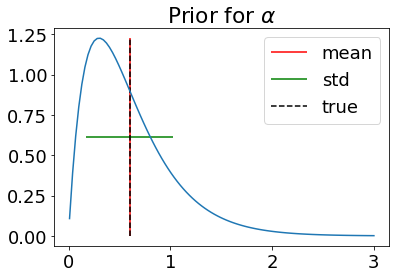

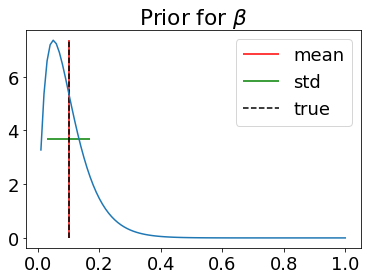

In [13]:
alpha1 = np.linspace(0.01,3,100)
palpha1 = ss.gamma.pdf(alpha1,prior_a_alpha_param,scale=prior_b_alpha_param)
plt.plot(alpha1,palpha1)
alpha_prior_mean = ss.gamma.mean(prior_a_alpha_param,scale=prior_b_alpha_param)
alpha_prior_std = ss.gamma.std(prior_a_alpha_param,scale=prior_b_alpha_param)
plt.vlines(alpha_prior_mean,ymin=0,ymax=np.max(palpha1[np.isfinite(palpha1)]),color='red',label='mean')
# plt.annotate(text='', xy=((alpha_prior_mean),np.max(palpha1)/2), xytext=((alpha_prior_mean+alpha_prior_std),np.max(palpha1)/2), arrowprops=dict(arrowstyle='<-',color='green',label='std'))
plt.hlines(np.max(palpha1)/2,xmin=(alpha_prior_mean-alpha_prior_std),xmax=(alpha_prior_mean+alpha_prior_std),color='green',label='std')
plt.vlines(alpha,ymin=0,ymax=np.max(palpha1[np.isfinite(palpha1)]),color='black',label='true',linestyle='dashed')
plt.title(r'Prior for $\alpha$')
plt.legend()
plt.show()

beta1 = np.linspace(0.01,1,100)
pbeta1 = ss.gamma.pdf(beta1,prior_a_beta_param,scale=prior_b_beta_param)
beta_prior_mean = ss.gamma.mean(prior_a_beta_param,scale=prior_b_beta_param)
beta_prior_std = ss.gamma.std(prior_a_beta_param,scale=prior_b_beta_param)
plt.plot(beta1,pbeta1)
plt.vlines(beta_prior_mean,ymin=0,ymax=np.max(pbeta1[np.isfinite(pbeta1)]),color='red',label='mean')
plt.hlines(np.max(pbeta1)/2,xmin=(beta_prior_mean-beta_prior_std),xmax=(beta_prior_mean+beta_prior_std),color='green',label='std')
plt.vlines(beta,ymin=0,ymax=np.max(pbeta1[np.isfinite(pbeta1)]),color='black',label='true',linestyle='dashed')
plt.title(r'Prior for $\beta$')
plt.legend()
plt.show()

if proposal_covariance[2,2] > 0:
    x1 = np.linspace(0.01,10,100)
    y1 = ss.gamma.pdf(x1,a=gamma_prior_a_sigma_param,scale=gamma_prior_b_sigma_param)
    plt.plot(x1,y1)
    plt.vlines(gamma_prior_a_sigma_param*gamma_prior_b_sigma_param,ymin=0,ymax=np.max(y1[~np.isnan(y1)]),color='red',label='mean')
    plt.title('Gamma prior')
    plt.legend()
    plt.show()

### Define key functions

In [242]:
# Vanilla Metropolis Hastings MCMC
def exponential_fd_log_prior(p):
    return ss.gamma.logpdf(p[0],prior_a_alpha_param,scale=prior_b_alpha_param)\
            + ss.gamma.logpdf(p[1],prior_a_beta_param,scale=prior_b_beta_param)#\
            #+ ss.gamma.logpdf(p[2],a=gamma_prior_a_sigma_param,scale=gamma_prior_b_sigma_param)
    
def exponential_fd_log_likelihood(p,y):
#     print('p',p[:-1])
    return np.sum([ss.lognorm.logpdf(y[i],s=np.sqrt(p[-1]),scale=exponential_fd(p[:-1])[i]) for i in range(y.shape[0])])
def exponential_fd_log_likelihood2(p,y):
    return np.sum([ss.lognorm.logpdf(x=y[i],s=np.sqrt(sigma2),scale=fundamental_diagram.simulate(p[:-1])[i]) for i in range(y.shape[0])])
def exponential_fd_log_target(p,y):
    # Log target is sum of priors and likelihood for each temperature
    return exponential_fd_log_prior(p) + exponential_fd_log_likelihood(p,y)

def gaussian_transition_kernel(p_prev,_beta,_cov):
    # Propose move
    return p_prev + _beta*np.random.multivariate_normal(np.zeros(p_prev.shape[0]),_cov)

### True unnormalised parameter posterior (based on target)

In [243]:
load_data = False
filename_extension = '_test'
#'','_concentrated'

In [244]:
# # Define grid quantities
# amin = 0.55#alpha_lower#0.18
# #alpha/3, 0.45
# amax = 0.65#alpha_upper#0.22
# #alpha*2 , 0.75
# bmin = 0.05#beta_lower#0.017
# #beta/3, 0.12
# bmax = 0.15#beta_upper#0.022
# #beta*2 ,0.08
# n_steps_a = 100# 22
# n_steps_b = 100

# a = np.linspace(amin,amax,n_steps_a)
# b = np.linspace(bmin,bmax,n_steps_b)
# # Create mesh
# B,A = np.meshgrid(b,a)
# # Compute unnormalised log posterior
# log_unnormalised_posterior_value = np.zeros((n_steps_a,n_steps_b))
# log_prior_value = np.zeros((n_steps_a,n_steps_b))
# log_likelihood_value = np.zeros((n_steps_a,n_steps_b))
# for i in tqdm(range(n_steps_a)):
#     for j in range(n_steps_b):
#         log_unnormalised_posterior_value[i,j] = exponential_fd_log_target([a[i],b[j],sigma2],q)
#         log_prior_value[i,j] = exponential_fd_log_prior([a[i],b[j],sigma2])
#         log_likelihood_value[i,j] = exponential_fd_log_likelihood([a[i],b[j],sigma2],q)
        
# #         print([a[i],b[j]])
# #         print(log_prior_value[i,j])

In [245]:
_vmin = np.min(log_unnormalised_posterior_value[np.isfinite(log_unnormalised_posterior_value)])
_vmax = np.max(log_unnormalised_posterior_value[np.isfinite(log_unnormalised_posterior_value)])
levels = np.linspace(_vmin,_vmax,20)
plt.ion()
plt.figure(figsize=(10,8))
# Create a contour
print(f'MAP = {A.flatten()[np.argmax(log_unnormalised_posterior_value)]}, beta={B.flatten()[np.argmax(log_unnormalised_posterior_value)]}')
B,A = np.meshgrid(b,a)
im = plt.contourf(A, B, log_unnormalised_posterior_value,levels)
plt.scatter(A.flatten()[np.argmax(log_unnormalised_posterior_value)],B.flatten()[np.argmax(log_unnormalised_posterior_value)],label='MAP',marker='x',s=200,color='blue',zorder=10)
plt.scatter(alpha,beta,label='OLS',marker='x',s=100,color='black',zorder=9)
plt.xlim([amin, amax])
plt.ylim([bmin, bmax])
plt.xlabel(r'$\alpha$',fontsize=16)
plt.ylabel(r'$\beta$',fontsize=16)
plt.title(r'Log unnormalised posterior',fontsize=18)
plt.colorbar(im)
plt.legend()

NameError: name 'log_unnormalised_posterior_value' is not defined

In [246]:
# if not load_data:
#     # Define grid quantities
#     amin = alpha_lower#0.18
#     #alpha/3, 0.45
#     amax = alpha_upper#0.22
#     #alpha*2 , 0.75
#     bmin = beta_lower#0.017
#     #beta/3, 0.12
#     bmax = beta_upper#0.022
#     #beta*2 ,0.08
#     n_steps_a = 100# 22
#     n_steps_b = 100
    
#     a = np.linspace(amin,amax,n_steps_a)
#     b = np.linspace(bmin,bmax,n_steps_b)
#     # Create mesh
#     B,A = np.meshgrid(b,a)
#     # Compute unnormalised log posterior
#     # log_unnormalised_posterior_value = log_exponential_fd_target_vector(A,B)
#     log_unnormalised_posterior_value = np.zeros((n_steps_a,n_steps_b))
#     for i in tqdm(range(n_steps_a)):
#         for j in range(n_steps_b):
#             log_unnormalised_posterior_value[i,j] = exponential_fd_log_target([a[i],b[j],sigma2],q)
#     Q_hat = copy.deepcopy(log_unnormalised_posterior_value)

#     # Export true posterior
#     np.savetxt(base_url+f'true_parameter_posterior{filename_extension}_sigma2_{str(sigma2).replace(".",",")}.txt',Q_hat)
#     np.savetxt(base_url+'rho.txt',rho)
#     np.savetxt(base_url+'q.txt',q)

#     true_posterior_metadata = {}
#     true_posterior_metadata['n_steps_a'] = n_steps_a
#     true_posterior_metadata['n_steps_b'] = n_steps_b
#     true_posterior_metadata['amin'] = amin
#     true_posterior_metadata['true_alpha'] = alpha
#     true_posterior_metadata['true_beta'] = beta
#     true_posterior_metadata['amax'] = amax
#     true_posterior_metadata['bmin'] = bmin
#     true_posterior_metadata['bmax'] = bmax
#     true_posterior_metadata['beta_prior_alpha_param'] = {'a':beta_prior_a_alpha_param,'b':beta_prior_b_alpha_param}
#     true_posterior_metadata['beta_prior_beta_param'] = {'a':beta_prior_a_beta_param,'b':beta_prior_b_beta_param}
    
    
#     # print(json.dumps(metadata, indent=2))

#     with open(base_url+f'true_parameter_posterior{filename_extension}_sigma2_{str(sigma2).replace(".",",")}_metadata.json', 'w') as outfile:
#         json.dump(true_posterior_metadata, outfile)
    
# else:
#     # LOAD DATA
    
#     # Load true posterior
#     Q_hat = np.loadtxt(base_url+f'true_parameter_posterior{filename_extension}_sigma2_{str(sigma2).replace(".",",")}.txt') 

#     # Load true posterior metadata
#     with open(base_url+f'true_parameter_posterior{filename_extension}_sigma2_{str(sigma2).replace(".",",")}_metadata.json') as json_file:
#         true_posterior_metadata = json.load(json_file)

#     # Define parameter grid 
#     a = np.linspace(true_posterior_metadata['amin'],true_posterior_metadata['amax'],true_posterior_metadata['n_steps_a'])
#     b = np.linspace(true_posterior_metadata['bmin'],true_posterior_metadata['bmax'],true_posterior_metadata['n_steps_b'])
#     # Create mesh
#     B,A = np.meshgrid(b,a)

#     # Store grid quantities
#     amin = true_posterior_metadata['amin']
#     amax = true_posterior_metadata['amax']
#     bmin = true_posterior_metadata['bmin']
#     bmax = true_posterior_metadata['bmax']
#     n_steps_a = true_posterior_metadata['n_steps_a']
#     n_steps_b = true_posterior_metadata['n_steps_b']
#     alpha = true_posterior_metadata['true_alpha']
#     beta = true_posterior_metadata['true_beta']
#     beta_prior_a_alpha_param = true_posterior_metadata['beta_prior_alpha_param']['a'] 
#     beta_prior_b_alpha_param = true_posterior_metadata['beta_prior_alpha_param']['b'] 
#     beta_prior_a_beta_param = true_posterior_metadata['beta_prior_beta_param']['a'] 
#     beta_prior_b_beta_param = true_posterior_metadata['beta_prior_beta_param']['b'] 

#     # Reshape
#     Q_hat = np.array(Q_hat).reshape((n_steps_a,n_steps_b))

### Plot unnormalised log posterior surface

In [247]:
# _vmin = 0#np.min(Q_hat[np.isfinite(Q_hat)])
# _vmax = np.max(Q_hat[np.isfinite(Q_hat)])

# plt.ion()
# plt.figure(figsize=(10,8))
# # Create a contour
# print(f'alpha_map = {A.flatten()[np.argmax(Q_hat)]}, beta={B.flatten()[np.argmax(Q_hat)]}')
# B,A = np.meshgrid(b,a)
# im = plt.contourf(A, B, Q_hat,600,vmin=_vmin,vmax=_vmax)
# plt.scatter(A.flatten()[np.argmax(Q_hat)],B.flatten()[np.argmax(Q_hat)],label='MAP',marker='x',s=200,color='blue',zorder=10)
# plt.scatter(alpha,beta,label='OLS',marker='x',s=100,color='black',zorder=9)
# plt.xlim([true_posterior_metadata['amin'], true_posterior_metadata['amax']])
# plt.ylim([true_posterior_metadata['bmin'], true_posterior_metadata['bmax']])
# plt.xlabel(r'$\alpha$',fontsize=16)
# plt.ylabel(r'$\beta$',fontsize=16)
# plt.title(r'Log unnormalised posterior',fontsize=18)
# plt.colorbar(im)
# plt.legend()

In [248]:
load_data = False

In [249]:
if load_data:
    grw_mcmc_parameters = np.loadtxt(base_url+method+'/'+filename+'.txt')
    grw_mcmc_parameters_proposed = np.loadtxt(base_url+method+'/'+filename+'_proposals.txt')
    grw_mcmc_acceptance = grw_posterior_metadata['acceptance']
else:
    grw_mcmc_parameters,grw_mcmc_parameters_proposed,grw_mcmc_acceptance = grw_mcmc(exponential_fd_log_target,
                                                            gaussian_transition_kernel,
                                                            np.array(parameters_init),
                                                            q,
                                                            proposal_covariance,
                                                            N,
                                                            beta_step,
                                                            2021,
                                                            False)
print('Metropolis Hastings Gaussian Random Walk MCMC')
print(f'Acceptance rate {int(grw_mcmc_acceptance*100)}%')

100%|██████████| 10/10 [00:00<00:00, 41.18it/s]

Metropolis Hastings Gaussian Random Walk MCMC
Acceptance rate 20%


In [250]:
grw_mcmc_parameters,grw_mcmc_parameters_proposed,grw_mcmc_acceptance

(array([[4.00000000e-01, 2.00000000e-01, 1.00000000e-04],
        [3.75804376e-01, 1.98350819e-01, 1.00000000e-04],
        [3.75804376e-01, 1.98350819e-01, 1.00000000e-04],
        [3.75804376e-01, 1.98350819e-01, 1.00000000e-04],
        [3.75804376e-01, 1.98350819e-01, 1.00000000e-04],
        [3.75804376e-01, 1.98350819e-01, 1.00000000e-04],
        [4.15323109e-01, 1.99039850e-01, 1.00000000e-04],
        [4.15323109e-01, 1.99039850e-01, 1.00000000e-04],
        [4.15323109e-01, 1.99039850e-01, 1.00000000e-04],
        [4.15323109e-01, 1.99039850e-01, 1.00000000e-04]]),
 array([[4.44658272e-01, 2.06413202e-01, 1.00000000e-04],
        [3.75804376e-01, 1.98350819e-01, 1.00000000e-04],
        [4.09730123e-01, 2.04469844e-01, 1.00000000e-04],
        [3.88469020e-01, 2.17750352e-01, 1.00000000e-04],
        [3.18572704e-01, 2.08788463e-01, 1.00000000e-04],
        [3.69051938e-01, 2.01751161e-01, 1.00000000e-04],
        [4.15323109e-01, 1.99039850e-01, 1.00000000e-04],
        [4.1

### Try plotting some proposals

Low noise example:

p_prev [0.58397071 0.09922669 0.05] lt_prev 69.40585499119092

p_new [0.57253006 0.10989284 0.05] lt_new -193.93808098002418

In [24]:
alpha_prev = alpha#0.58397071 #0.5868189#0.58397071
beta_prev = beta#0.09922669#0.0986835 #0.09922669

alpha_new = 0.59#0.57253006#0.61384857#0.57253006
beta_new = 0.098#0.10989284#0.09545316#0.10989284

q_prev = exponential_fd([alpha_prev,beta_prev])
q_new = exponential_fd([alpha_new,beta_new])

print(f'p_prev = {[alpha_prev,beta_prev,sigma2]}, lt_prev = {exponential_fd_log_target([alpha_prev,beta_prev,sigma2],q)}')
print(f'p_new = {[alpha_new,beta_new,sigma2]}, lt_new = {exponential_fd_log_target([alpha_new,beta_new,sigma2],q)}')

p_prev = [0.6, 0.1, 0.05], lt_prev = 1983.0222092008166
p_new = [0.59, 0.098, 0.05], lt_new = 1870.2852927468236


In [25]:
# plt.figure(figsize=(10,10))
# plt.scatter(rho,q,color='black',alpha=0.1,label='true')
# plt.plot(rho,q_prev,color='red',label='previous')
# plt.plot(rho,q_new,color='blue',label='new')
# plt.xlabel(r'$\rho$')
# plt.ylabel(r'$q$')
# plt.legend()

In [26]:
_vmin = 0#np.min(Q_hat[np.isfinite(Q_hat)])
_vmax = np.max(Q_hat[np.isfinite(Q_hat)])
_n = 40

levels = np.linspace(_vmin, _vmax, _n)
plt.ion()
plt.figure(figsize=(10,8))
# Create a contour
print(f'alpha_map = {A.flatten()[np.argmax(Q_hat)]}, beta={B.flatten()[np.argmax(Q_hat)]}')
B,A = np.meshgrid(b,a)
im = plt.contourf(A, B, Q_hat, levels=levels)
plt.scatter(A.flatten()[np.argmax(Q_hat)],B.flatten()[np.argmax(Q_hat)],label='MAP',marker='x',s=200,color='blue',zorder=10)
plt.scatter(alpha,beta,label='OLS',marker='x',s=100,color='black',zorder=9)
plt.scatter(alpha_prev,beta_prev,label='p_prev',marker='x',s=100,color='red',zorder=11)
# plt.scatter(alpha_new,beta_new,label='p_new',marker='x',s=100,color='purple',zorder=8)
plt.xlim([true_posterior_metadata['amin'], true_posterior_metadata['amax']])
plt.ylim([true_posterior_metadata['bmin'], true_posterior_metadata['bmax']])
plt.xlabel(r'$\alpha$',fontsize=16)
plt.ylabel(r'$\beta$',fontsize=16)
plt.title(r'Log unnormalised posterior',fontsize=18)
plt.colorbar(im)
plt.legend()

NameError: name 'Q_hat' is not defined

### Compute Gelman Rubin convergence diagnostic

In [27]:
grw_mcmc_gelman_rubin_statistic = gelman_rubin_statistic(grw_mcmc_parameters[1:,])

MCMC chains have NOT converged with $\hat{R}$= 14.348641434787488 ...


### Inspect samples 

In [30]:
# Define burnin
burnin = 0
export_data = False

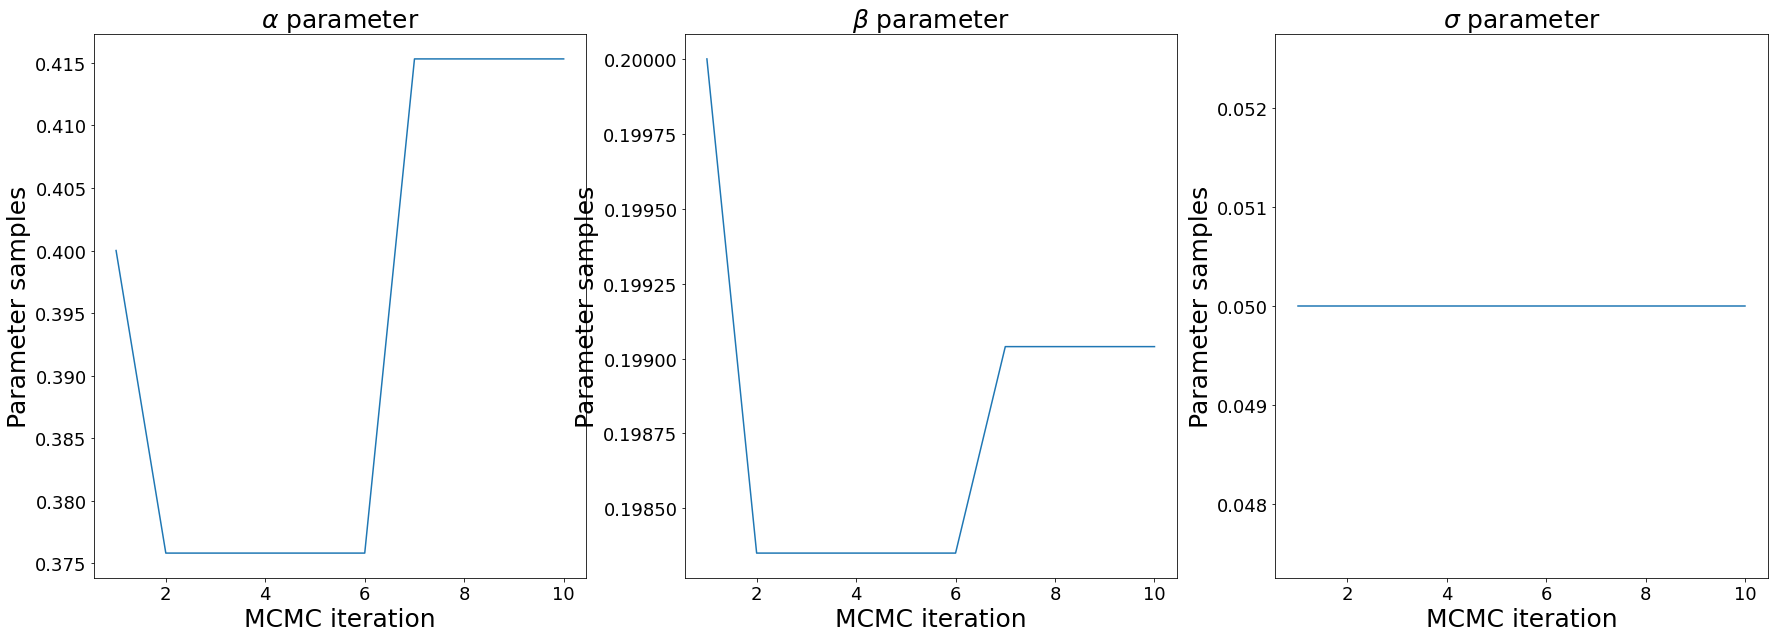

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=num_params,figsize=(30,10))
for i in range(1,num_params+1):
    plt.subplot(1,num_params,i)
    plt.title(f'{param_names[i-1]} parameter',fontsize=25)
    plt.plot(range(burnin+1,N+1),grw_mcmc_parameters[burnin:,i-1],label='Sampled chains')
    plt.ylabel('Parameter samples',fontsize=25)
    plt.xlabel('MCMC iteration',fontsize=25)
    plt.ioff()
if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_mixing.png')


In [33]:
grw_mcmc_parameters[burnin:,1]

array([0.2       , 0.19835082, 0.19835082, 0.19835082, 0.19835082,
       0.19835082, 0.19903985, 0.19903985, 0.19903985, 0.19903985])

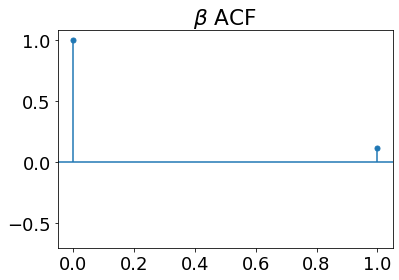

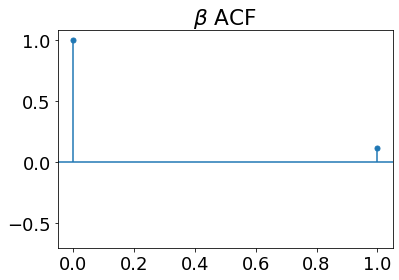

In [35]:
sm.graphics.tsa.plot_acf(grw_mcmc_parameters[burnin:,1], lags=1,title=r'$\beta$ ACF')

ValueError: could not broadcast input array from shape (10,) into shape (101,)

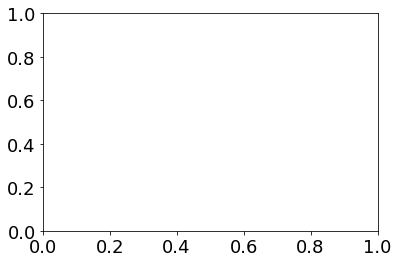

In [32]:
# Plot autocorrelation function
sm.graphics.tsa.plot_acf(grw_mcmc_parameters[burnin:,0], lags=100,title=r'$\alpha$ ACF')
if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_alpha_acf.png')
sm.graphics.tsa.plot_acf(grw_mcmc_parameters[burnin:,1], lags=100,title=r'$\beta$ ACF')
if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_beta_acf.png')
plt.show()

alpha_map = 0.6041812044347173, beta=0.10015400471316754


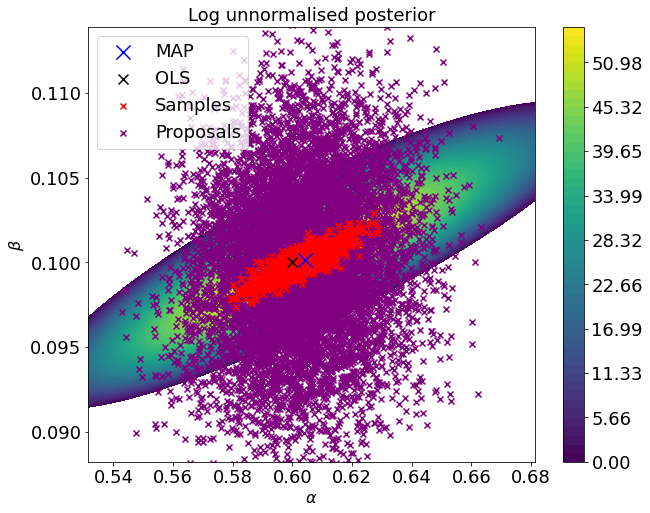

In [220]:
_vmin = 0#np.min(Q_hat[np.isfinite(Q_hat)])
_vmax = np.max(Q_hat[np.isfinite(Q_hat)])
_n = 50

levels = np.linspace(_vmin, _vmax, _n)
i = -1
# for i in range(0,N,N//10):
plt.figure(figsize=(10,8))
# Create a contour
if len(Q_hat.shape) == 3:
    A,B = np.meshgrid(a,b)
    Q_hat_marginal = np.sum(Q_hat,axis=2)
    im = plt.contourf(A, B, Q_hat_marginal, levels=levels)
    plt.scatter(A.flatten()[np.argmax(Q_hat_marginal)],B.flatten()[np.argmax(Q_hat_marginal)],label='MAP',marker='x',s=200,color='blue',zorder=10)
else:
    print(f'alpha_map = {A.flatten()[np.argmax(Q_hat)]}, beta={B.flatten()[np.argmax(Q_hat)]}')
    B,A = np.meshgrid(b,a)
    im = plt.contourf(A, B, Q_hat, levels=levels)
    plt.scatter(A.flatten()[np.argmax(Q_hat)],B.flatten()[np.argmax(Q_hat)],label='MAP',marker='x',s=200,color='blue',zorder=10)
plt.scatter(alpha,beta,label='OLS',marker='x',s=100,color='black',zorder=9)
plt.scatter(grw_mcmc_parameters[burnin:i,0],grw_mcmc_parameters[burnin:i,1],label='Samples',marker='x',color='red',zorder=2)
plt.scatter(grw_mcmc_parameters_proposed[burnin:i,0],grw_mcmc_parameters_proposed[burnin:i,1],label='Proposals',marker='x',color='purple',zorder=1)
plt.xlim([true_posterior_metadata['amin'], true_posterior_metadata['amax']])
plt.ylim([true_posterior_metadata['bmin'], true_posterior_metadata['bmax']])
plt.xlabel(r'$\alpha$',fontsize=16)
plt.ylabel(r'$\beta$',fontsize=16)
plt.title(r'Log unnormalised posterior',fontsize=18)
plt.colorbar(im)
plt.legend()
#     plt.pause(0.05)

if export_data: plt.savefig(base_url+method+'/figures/'+filename+'_2d_mixing.png')

### Marginal likelihood estimation

We use the posterior harmonic mean of the likelihood values i.e.

$$Z = \left[\frac{1}{N} \sum_{i=1}^N p(\mathbf{y}|\theta^{(i)})^{-1}\right]^{-1}$$

or equivalently

$$\log(Z) = -\log\left(-\log(N) -\sum_{i=1}^N p(\mathbf{y}|\theta^{(i)})\right)$$

In [77]:
def log_posterior_harmonic_mean(param_posterior,y,log_likelihood):
    # Get number of MCMC iterations
    _N = param_posterior.shape[0]
    # Initialise marginal likelihood
    lml = -np.log(_N)
    # Loop over MCMC iterations
    for i in tqdm(range(_N)):
        # Update sum in log posterior harmonic mean estimator 
        lml -= log_likelihood(param_posterior[i,:],y)
        
    return -np.log(lml)
    

In [24]:
load_data = True

In [25]:
# if not load_data:
#     exponential_fd_lml = log_posterior_harmonic_mean(grw_mcmc_parameters[burnin:,:],q,exponential_fd_log_likelihood)
# else:
#     exponential_fd_lml = grw_posterior_metadata['log_marginal_likelihood']

# print('Log marginal likelihood =',exponential_fd_lml)

In [325]:
burnin = 2000
file = "/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/inference_experiments/exponential_fd_simulation_small/grwmh/grwmh_inference_wide_gamma_priors_sigma2_fixed/grwmh_inference_wide_gamma_priors_sigma2_fixed_theta.txt"
grw_mcmc_parameters = np.loadtxt(file)

grw_mcmc_parameters = np.hstack((grw_mcmc_parameters,(np.ones((grw_mcmc_parameters.shape[0],1))*sigma2)))

# Compute Gelman and Rubin criterion

In [347]:
# def gelman_rubin_statistic_naive(posterior_samples):
#     _n = chain1[burn_in:burn_in+length].shape[0]

#     _W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
#     _mean1 = chain1[burn_in:burn_in+length].mean()
#     _mean2 = chain2[burn_in:burn_in+length].mean()
#     _mean = (mean1 + mean2)/2
#     _B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
#     _var_theta = (1 - 1/n) * W + 1/n*B
#     print("Gelmen-Rubin Diagnostic: ", np.sqrt(var_theta/W))

def gelman_rubin_statistic(posterior_samples):
    _n = posterior_samples[burnin:,:].shape[0]
    
    temp = np.array([np.std(posterior_samples[burnin:,i],axis=0)**2 for i in range(2)])
    print(np.mean(temp,axis=0))
    _W = np.mean([np.std(posterior_samples[burnin:,i],axis=0)**2 for i in range(2)],axis=0)
    print(_W)
    chain_means = np.mean(posterior_samples[burnin:,:],axis=0)
    print('chain_means',chain_means)
    chain_mean = np.mean(chain_means)
    print('chain_mean',chain_mean)
    _B = _n * np.sum([(chain_means[i]-chain_mean)**2 for i in range(2)])
    print(_B)
    _var_theta = (1 - 1/_n) * _W + 1/_n*_B
    print("Gelmen-Rubin Diagnostic: ", np.sqrt(_var_theta/_W))

# Plot posterior fit

In [120]:
alpha_mean = np.mean(grw_mcmc_parameters[burnin:,0])
alpha_std = np.std(grw_mcmc_parameters[burnin:,0])

beta_mean = np.mean(grw_mcmc_parameters[burnin:,1])
beta_std = np.std(grw_mcmc_parameters[burnin:,1])

alpha_upper_bound = alpha_mean + 2*alpha_std
beta_upper_bound = beta_mean + 2*beta_std

alpha_lower_bound = alpha_mean - 2*alpha_std
beta_lower_bound = beta_mean - 2*beta_std

q_hat_upper_bound = exponential_fd([alpha_upper_bound,beta_lower_bound])
q_hat_mean = exponential_fd([alpha_mean,beta_mean])
q_hat_lower_bound = exponential_fd([alpha_lower_bound,beta_upper_bound])

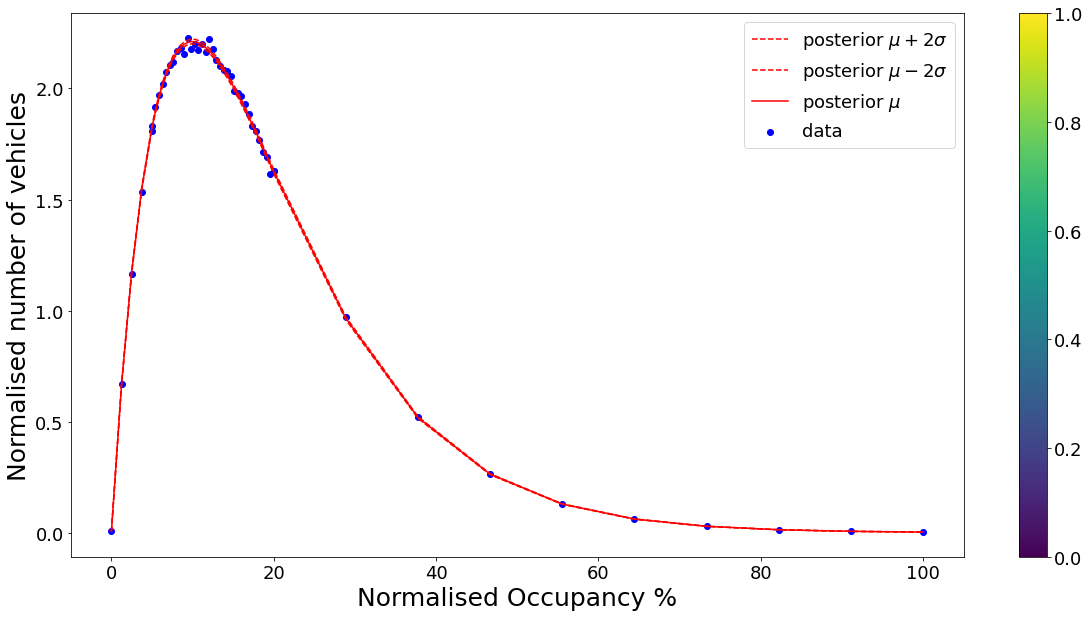

In [121]:
plt.figure(figsize=(20,10))
plt.scatter(rho,q,label='data',color='blue')
plt.plot(rho,q_hat_upper_bound,label=r'posterior $\mu+2\sigma$',color='red',linestyle='dashed')
plt.plot(rho,q_hat_lower_bound,label=r'posterior $\mu-2\sigma$',color='red',linestyle='dashed')
plt.plot(rho,q_hat_mean,label=r'posterior $\mu$',color='red')
plt.ylabel('Normalised number of vehicles',fontsize=25)
plt.xlabel('Normalised Occupancy %',fontsize=25)
plt.colorbar()
plt.legend()

# if export_data: plt.savefig(base_url+method+'/'+filename+'_data_fit.png')

### Posterior predictive computation

In [122]:
import time

In [123]:
def exponential_fd_given_rho(p,r):
    return p[0]*r*np.exp(-p[1]*r)

def exponential_fd_log_likelihood(p,y):
#     print('p',p[:-1])
    return np.sum([ss.lognorm.logpdf(y[i],s=np.sqrt(p[-1]),scale=exponential_fd(p[:-1])[i]) for i in range(y.shape[0])])

def exponential_fd_predictive_log_likelihood(p,y,x):
    return np.sum([ss.lognorm.logpdf(y,s=np.sqrt(p[-1]),scale=exponential_fd_given_rho(p,x[i])) for i in range(x.shape[0])])

def exponential_fd_log_likelihood_sample(p,x):
    return np.array([np.random.lognormal(mean=np.log(exponential_fd_given_rho(p,x[i])),sigma=np.sqrt(p[-1])) for i in range(x.shape[0])])

def exponential_fd_log_likelihood_sample_squared(p,x):
    return np.array([np.random.lognormal(mean=np.log(exponential_fd_given_rho(p,x[i])),sigma=np.sqrt(p[-1]))**2 for i in range(x.shape[0])])


def posterior_predictive_moments(samples,y,x):
    np.random.seed(2021)
    pp_y = np.zeros(y.shape[0])
    pp_y_squared = np.zeros(y.shape[0])
    for j in tqdm(range(samples.shape[0])):
        pp_y += exponential_fd_log_likelihood_sample(samples[j,:],x)
        pp_y_squared += exponential_fd_log_likelihood_sample_squared(samples[j,:],x)
        
    pp_mean = pp_y/samples.shape[0]
    pp_std = pp_y_squared/samples.shape[0] - pp_mean**2
    return pp_mean,pp_std

def posterior_predictive_moments_fast(samples,y,x):
    np.random.seed(2021)
    tic = time.perf_counter()    
    pp_mean = np.sum([exponential_fd_log_likelihood_sample(samples[j,:],x) for j in range(samples.shape[0])],axis=0)/samples.shape[0]
    pp_std = np.sum([exponential_fd_log_likelihood_sample(samples[j,:],x)**2 for j in range(samples.shape[0])],axis=0)/samples.shape[0] - pp_mean**2
    
    toc = time.perf_counter()
    print(f"Computed posterior predictive in {toc - tic:0.4f} seconds")
    return pp_mean,pp_std

In [124]:
# grw_posterior_predictive_mean,grw_posterior_predictive_std = posterior_predictive_moments(grw_mcmc_parameters[burnin:,:],q,rho)

# grw_posterior_predictive_fast_mean,grw_posterior_predictive_fast_std = posterior_predictive_moments_fast(grw_mcmc_parameters[burnin:,:],q,rho)


In [125]:
q_upper = grw_posterior_predictive_fast_mean + 2 * grw_posterior_predictive_fast_std
q_lower = grw_posterior_predictive_fast_mean - 2 * grw_posterior_predictive_fast_std


plt.figure(figsize=(10,10))
plt.scatter(rho,q,label='data')
plt.fill_between(rho,q_upper,q_lower,alpha=0.5,color='red')
# plt.plot(rho,q_lower,color='r',label=f'posterior predictive mean + 2sd')
plt.plot(rho,grw_posterior_predictive_mean,color='b',label='posterior predictive mean')
# plt.plot(rho,q_upper,color='r',label=f'posterior predictive mean - 2sd')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$q$')
plt.legend()
plt.ioff()

NameError: name 'grw_posterior_predictive_fast_mean' is not defined

In [126]:
q_upper = grw_posterior_predictive_mean + 2 * grw_posterior_predictive_std
q_lower = grw_posterior_predictive_mean - 2 * grw_posterior_predictive_std


plt.figure(figsize=(10,10))
plt.scatter(rho,q,label='data')
plt.plot(rho,q_lower,color='r',label=f'posterior predictive mean + 2sd')
plt.plot(rho,grw_posterior_predictive_mean,color='b',label='posterior predictive mean')
plt.plot(rho,q_upper,color='r',label=f'posterior predictive mean - 2sd')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$q$')
plt.legend()
plt.ioff()

NameError: name 'grw_posterior_predictive_mean' is not defined

### Marginal likelihood estimation

We use the posterior harmonic mean of the likelihood values i.e.

$$Z = \left[\frac{1}{N} \sum_{i=1}^N p(\mathbf{y}|\theta^{(i)})^{-1}\right]^{-1}$$

or equivalently

$$\log(Z) = -\log\left(-\log(N) -\log(\sum_{i=1}^N p(\mathbf{y}|\theta^{(i)}))\right)$$

In [139]:
def exponential_fd_log_likelihood(p,y):
#     print('p',p[:-1])
    return np.sum([ss.lognorm.logpdf(y[i],s=np.sqrt(p[-1]),scale=exponential_fd(p[:-1])[i]) for i in range(y.shape[0])])

def log_posterior_harmonic_mean(param_posterior):
    # Get number of MCMC iterations
    _N = param_posterior.shape[0]
    # Initialise marginal likelihood
#     ml = (_N**(-1) * np.sum([np.exp(evaluate_log_likelihood(param_posterior[i,:]))**(-1) for i in range(_N)]))**(-1)
    ml = 0
    for i in tqdm(range(_N)):
        term = np.exp(exponential_fd_log_likelihood(param_posterior[i,:],q))**(-1)
        if ~np.isfinite(term):
            print(term)
        ml += term
        
    return _N * (ml)**(-1)
    

In [140]:
ml = log_posterior_harmonic_mean(grw_mcmc_parameters[burnin:,:])

100%|██████████| 8000/8000 [01:21<00:00, 98.24it/s] 


In [141]:
print("Marginal likelihood:",ml)
print("Log marginal likelihood:",np.log(ml))

Marginal likelihood: 7.167126237400354e+70
Log marginal likelihood: 163.1504612801416


# Log marginal likelihood estiation from thermodynamic integration

In [366]:
burnin=5000

file = "/Users/Yannis/code/probabilistic_traffic_flow_modelling/data/output/inference_experiments/exponential_fd_simulation_small/grwmh/grwmh_inference_wide_gamma_priors_sigma2_fixed/grwmh_inference_wide_gamma_priors_sigma2_fixed_thermodynamic_integration_theta.txt"
grwmh_thermondynamic_samples = np.loadtxt(file)
grwmh_thermondynamic_samples = grwmh_thermondynamic_samples.reshape((10000,20,2))
grwmh_thermondynamic_samples = np.dstack((grwmh_thermondynamic_samples,(np.ones((grwmh_thermondynamic_samples.shape[0],grwmh_thermondynamic_samples.shape[1],1))*sigma2)))

# Compute log marginal likelihood

The log marginal likelihood is equal to 

$$\log(Z_t) = \sum_{i=1}^n \log(Z_{t_{i}})$$

and is calculated from

$$\log(p(\mathbf{y})) = \lim_{\Delta t \to 0} \sum_{i=1}^n  \mathbb{E}_{\theta|\mathbf{y},t_i}\left[\log(p(\mathbf{y}|\theta)\right] \Delta t \approx  \sum_{i=1}^n \sum_{j=1}^N \log(p(\mathbf{y}|\theta_i^{(j)}) \Delta t$$

where $\theta_i^{(j)}$ are samples from the population MCMC-inferred posterior $p(\theta|\mathbf{y},t_i)$.


In [367]:
# Uniform geometric-based temperature schedule
def uniform_t(_n):
    return np.array([i/_n for i in range(1,_n+1)]).reshape((_n,1))

# Prior geometric-based temperature schedule
def prior_t(_n,_p):
    return np.array([(i/_n)**_p for i in range(1,_n+1)]).reshape((_n,1))

# Posterior geometric-based temperature schedule
def posterior_t(_n,_p):
    return np.array([(1-(i/_n)**_p) for i in range(1,_n+1)]).reshape((_n,1))

def exponential_fd_log_marginal_likelihood(learned_params,temp_schedule):
    
    # Store length of temperature schedule
    t_len = temp_schedule.shape[0]
    
    # Get number of MCMC iterations
    num_iters = learned_params.shape[0]
    
    # Initiliase lml 
    lml = 0    
#     return np.sum([(temp_schedule[ti] - temp_schedule[ti-1]) * np.sum([exponential_fd_log_likelihood(learned_params[j,:,:],ti,y,sigma_2) for ti in range(1,t_len) for j in range(num_iters)])])
    
    # Loop temperature indices
    for ti in tqdm(range(1,t_len)):
        # Compute Delta t
        delta_t = temp_schedule[ti] - temp_schedule[ti-1]
#         print('delta_t',delta_t)
        # Loop through each iteration
        for j in range(burnin,num_iters):
            term = exponential_fd_log_likelihood(learned_params[j,ti,:],q)
#             print('learned_params[j,ti,:]',learned_params[j,ti,:])
#             print('deltat',delta_t)
#             print('term',term)
#             sys.exit(1)
            # Compute posterior expectation
            lml += delta_t*term
    
    return lml

In [368]:
temperature_schedule = prior_t(20,5)
grwmh_thermondynamic_lml = exponential_fd_log_marginal_likelihood(grwmh_thermondynamic_samples,temperature_schedule)

100%|██████████| 19/19 [01:26<00:00,  4.55s/it]


In [372]:
grwmh_thermondynamic_lml[0]

array([-2.6893837e+08])

# Compute Gelman and Rubin criterion

In [350]:
def gelman_rubin_statistic(posterior_samples):
    _n = posterior_samples[burnin:,:,:].shape[0]
    _t_len = len(temperature_schedule)
    
    temp = np.array([np.std(posterior_samples[burnin:,ti,:],axis=1)**2 for ti in range(_t_len)])
    print(np.mean(temp,axis=0))
    _W = np.mean([np.std(posterior_samples[burnin:,ti,:],axis=0)**2 for ti in range(_t_len)],axis=0)
    print(_W)
    chain_means = np.mean(posterior_samples[burnin:,:,:],axis=0)
    chain_mean = np.mean(chain_means,axis=0)
    _B = _n * np.sum([(chain_means[i,:]-chain_mean)**2 for i in range(_t_len)])
    print(_B)
    _var_theta = (1 - 1/_n) * _W + 1/_n*_B
    print("Gelman-Rubin Diagnostic: ", np.sqrt(_var_theta/_W))

In [349]:
gelman_rubin_statistic(grwmh_thermondynamic_samples)

[0.02737549 0.02737544 0.02737544 ... 0.03312323 0.033123   0.03312194]
[1.15958818e-04 2.16446363e-04 8.04927104e-35]
9.217267668786226
Gelmen-Rubin Diagnostic:  [3.30693255e+00 2.51454605e+00 3.78336142e+15]


### Adding constants to parameter posterior mean and std (useless)

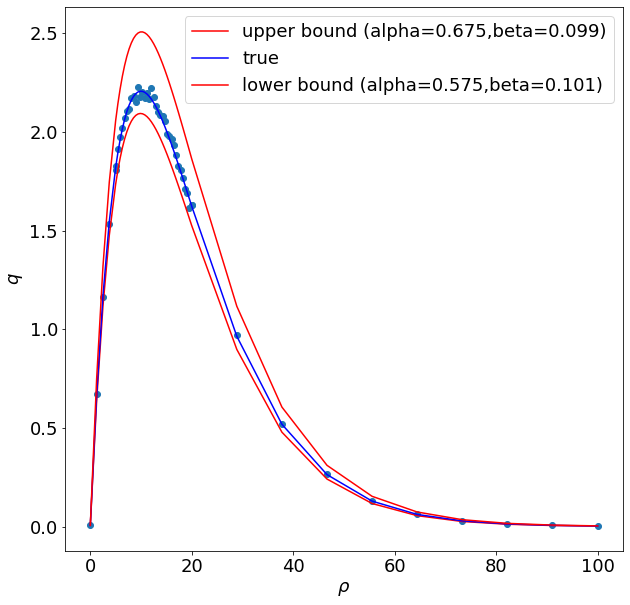

In [130]:
alpha_upper = 0.675#np.max(grw_mcmc_parameters[burnin:,:],axis=0)[0] + 0.05
beta_upper = 0.101#np.max(grw_mcmc_parameters[burnin:,:],axis=0)[1] + 0.01

alpha_lower = 0.575#np.min(grw_mcmc_parameters[burnin:,:],axis=0)[0] - 0.05
beta_lower = 0.099#np.min(grw_mcmc_parameters[burnin:,:],axis=0)[1] - 0.01
    
q_upper = exponential_fd([alpha_upper,beta_lower])
q_lower = exponential_fd([alpha_lower,beta_upper])

plt.figure(figsize=(10,10))
plt.scatter(rho,q)
plt.plot(rho,q_lower,color='r',label=f'upper bound (alpha={alpha_upper},beta={beta_lower})')
plt.plot(rho,q_true,color='b',label='true')
plt.plot(rho,q_upper,color='r',label=f'lower bound (alpha={alpha_lower},beta={beta_upper})')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$q$')
plt.legend()
plt.ioff()

### Export data

In [131]:
# Flag for exporting data
export_data = True

In [132]:
if export_data:
    # Export MCMC chains
    np.savetxt(base_url+method+'/'+filename+'.txt',grw_mcmc_parameters)
    np.savetxt(base_url+method+'/'+filename+'_proposals.txt',grw_mcmc_parameters)
    
    # Compile metadata
    grw_posterior_metadata = {}
    grw_posterior_metadata['acceptance'] = grw_mcmc_acceptance
    grw_posterior_metadata['gelman_rubin_statistic'] = grw_mcmc_gelman_rubin_statistic
#     grw_posterior_metadata['log_marginal_likelihood'] = exponential_fd_lml
    grw_posterior_metadata['N'] = N
    grw_posterior_metadata['true_alpha'] = alpha
    grw_posterior_metadata['true_beta'] = beta
    grw_posterior_metadata['beta_step'] = beta_step
    grw_posterior_metadata['beta_prior_alpha_param'] = {'a':beta_prior_a_alpha_param,'b':beta_prior_b_alpha_param}
    grw_posterior_metadata['beta_prior_beta_param'] = {'a':beta_prior_a_beta_param,'b':beta_prior_b_beta_param}
    grw_posterior_metadata['gamma_prior_sigma_param'] = {'a':gamma_prior_a_sigma_param,'b':gamma_prior_b_sigma_param}
    grw_posterior_metadata['initial_parameters'] = list(parameters_init)
    grw_posterior_metadata['proposal_variances'] = list(np.diag(proposal_covariance))

    # Export metadata
#     print(json.dumps(grw_posterior_metadata,indent=2))

    with open(base_url+method+'/'+filename+'_metadata.json', 'w') as outfile:
        json.dump(grw_posterior_metadata, outfile)

FileNotFoundError: [Errno 2] No such file or directory: '../data/output/models/synthetic/exponential_fd/grwmh_mcmc/grw_parameter_posterior_fixed_sigma2_0,0001_test.txt'